# Experimental Data Classification with Machine Learning

This notebook classifies time series data from two experimental conditions using SVM, LSTM, and Transformer models.

**Experiments:**
- 19316_2020_10_26_steadystate_glucose_144m_2w2_00 (label: 0)
- 20213_2021_09_07_steady_0p01glc_1344_1346_1347_00 (label: 1)

**Target:** CV_mCherry time series classification

<span style='color: red'>**== Run this notebook using the wela virtual environment ==**</span>

In [19]:
from wela.autocrosscorr import autocrosscorr
from wela.plotting import plot_column_from_tsv
from wela.get_exp_conditions import get_exp_summary # this is the function to print the experiment summary
from wela.calculate_stats import load_tsv, calculate_budding_intervals, calculate_cv, calculate_fano_factor, calculate_autocorrelation, calculate_ac_time_interp1d

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import warnings
from tqdm import tqdm
import glob

from scipy.interpolate import interp1d
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [52]:
# Define experiment metadata
omids = [
    '19316_2020_10_26_steadystate_glucose_144m_2w2_00',  # label: 0, 2% gluc
    '20213_2021_09_07_steady_0p01glc_1344_1346_1347_00',  # label: 1, 0.01% gluc
    '19566_2020_12_07_steadystate_glucose_1344m_2w0p1_01', # 0.1% gluc
    '19554_2020_12_06_steadystate_glucose_2w0p01_900m_00' # 0.01% gluc
]

# the acq and log files to get the exp descriptions
acq_file_path = glob.glob(f"/home/ianyang/alibylite/high_quality_data_analysis/{omids[0]}/*Acq.txt")[0]
log_file_path = glob.glob(f"/home/ianyang/alibylite/high_quality_data_analysis/{omids[0]}/*log.txt")[0]
# we only need the tf_df as a variable
_, tf_df, _ = get_exp_summary(acq_file_path, log_file_path)
print(f"Loading data for experiment: {omids[0]}")
# we want the post media switch data
# Note this is not steady state yet...
tsv_path = f"/home/ianyang/stochastic_simulations/experiments/EXP-25-IY010/exp_data/{omids[0]}_post_media_switch.tsv"
column_name = 'CV_mCherry' # change this to 'CV_GFP' for GFP analysis
df_1 = load_tsv(tsv_path)
# group names
group_names = df_1['group'].unique().tolist()
# Convert group_names to strings to match tf_df['group'] data type
group_names_str = [str(g) for g in group_names]

# extract the TF being tracked by using the group_names as index
tf = tf_df.loc[tf_df['group'].isin(group_names_str), 'mCherry TF']
tf.values[0]

=== EXPERIMENT SUMMARY ===

📸 IMAGING SETUP (from acquisition file):
• Channels: ['Brightfield', 'GFP', 'mCherry']
• Exposure times: [30, 30, 100] ms
• Camera EM gain: 270

⏱️ TIME-LAPSE SETTINGS:
• Time interval: 120 seconds (2.0 minutes)
• Number of timepoints: 540
• Total experiment time: 64800 seconds (18.0 hours)

🧪 MICROFLUIDICS SETUP:
• Number of pumps: 2
• Pump rates: [[0.0], [4.0]]
• Pump contents: ['2% glucose in SC', '2% glucose in SC']
• Number of switches: 1
• Switch volumes: 50
• Switch rates: 100
• Switch times: [180]

🔬 MICROSCOPE SETUP (from log file):
• Microscope: Batgirl
• Date: 2020-10-25 00:00:00
• Experiment start time: 2020-10-25 17:09:13
• Capture of the first image: 2020-10-25 17:09:14
• MultiDGUI commit: 29bfe736500ed3f8be9c19585bee78cc67ceae26
• Experimental details: Aim:   Strain:   Comments:   Strains 1344 and 1346 were both labelled 1346 in the subculturing so not sure which is which.

💾 OMERO INFORMATION:
• Project: SteadystateGlucose
• Tags: ['25-Oct-20

'Msn2'

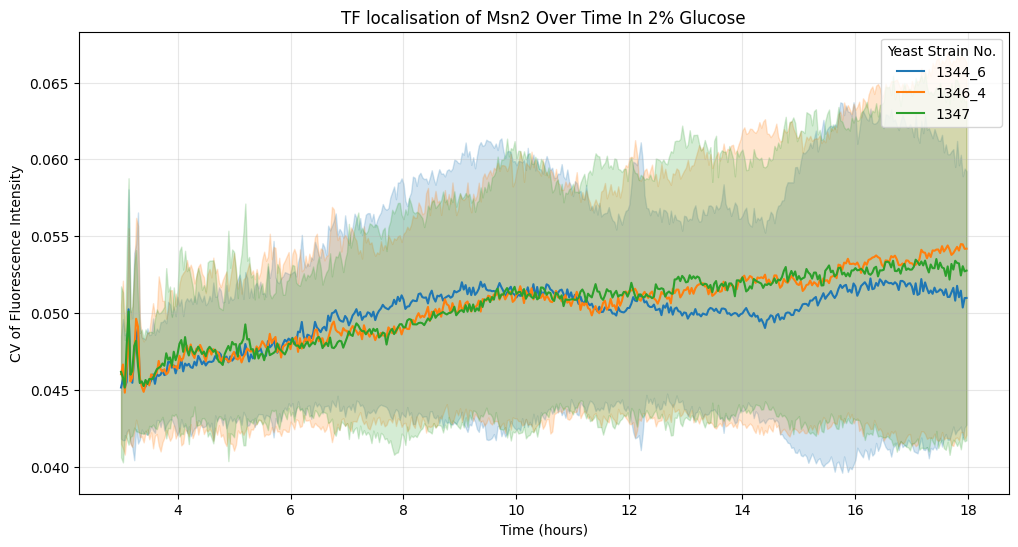

In [53]:
# Plot the required column over time for different groups
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_1, x='time', y=column_name, hue='group', errorbar='sd')
plt.legend(title=f'Yeast Strain No.')
plt.title(f'TF localisation of {tf.values[0]} Over Time In 2% Glucose')
plt.xlabel('Time (hours)')
plt.ylabel(f'CV of Fluorescence Intensity')
plt.grid(True, alpha=0.3)
plt.show()

## Let's look at a different experiment

In [54]:
# the acq and log files to get the exp descriptions
acq_file_path = glob.glob(f"/home/ianyang/alibylite/high_quality_data_analysis/{omids[1]}/*Acq.txt")[0]
log_file_path = glob.glob(f"/home/ianyang/alibylite/high_quality_data_analysis/{omids[1]}/*log.txt")[0]
# we only need the tf_df as a variable
_, tf_df, _ = get_exp_summary(acq_file_path, log_file_path)
print(f"Loading data for experiment: {omids[1]}")
# we want the post media switch data
# Note this is not steady state yet...
tsv_path = f"/home/ianyang/stochastic_simulations/experiments/EXP-25-IY010/exp_data/{omids[1]}_post_media_switch.tsv"
column_name = 'CV_mCherry' # change this to 'CV_GFP' for GFP analysis
df_2 = load_tsv(tsv_path)
# group names
group_names = df_2['group'].unique().tolist()

# extract the TF being tracked by using the group_names as index
# Convert group_names to strings to match tf_df['group'] data type
group_names_str = [str(g) for g in group_names]
tf = tf_df.loc[tf_df['group'].isin(group_names_str), 'mCherry TF']

=== EXPERIMENT SUMMARY ===

📸 IMAGING SETUP (from acquisition file):
• Channels: ['Brightfield', 'GFP', 'mCherry']
• Exposure times: [30, 30, 100] ms
• Camera EM gain: 270

⏱️ TIME-LAPSE SETTINGS:
• Time interval: 120 seconds (2.0 minutes)
• Number of timepoints: 540
• Total experiment time: 64800 seconds (18.0 hours)

🧪 MICROFLUIDICS SETUP:
• Number of pumps: 2
• Pump rates: [[-0.5], [4.5]]
• Pump contents: ['2% glucose in SC', '0.01% glucose in SC']
• Number of switches: 1
• Switch volumes: 50
• Switch rates: 100
• Switch times: [180]

🔬 MICROSCOPE SETUP (from log file):
• Microscope: Batgirl
• Date: 2021-09-06 00:00:00
• Experiment start time: 2021-09-06 17:18:07
• Capture of the first image: 2021-09-06 17:18:10
• MultiDGUI commit: e1ef7279bc3687c771624cf3b9503671aa6d7cea
• Experimental details: Aim: Record steady state TF dynamics in 0.01% glucose
Strains:
1344- Cat8-GFP Msn2-mCh
1346- Nrg1-GFP Msn2-mCh
1347- Rtg1-GFP Msn2-mCh
Comments:
Use Kevin's dilution sheet to prepare O/N (st

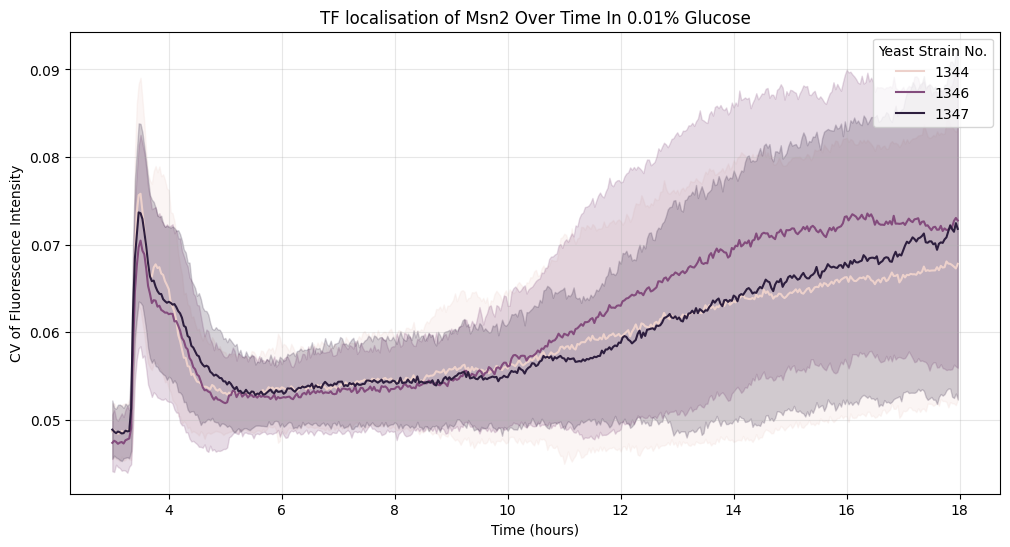

In [55]:
# Plot the required column over time for different groups
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_2, x='time', y=column_name, hue='group', errorbar='sd')
plt.legend(title=f'Yeast Strain No.')
plt.title(f'TF localisation of {tf.values[0]} Over Time In 0.01% Glucose')
plt.xlabel('Time (hours)')
plt.ylabel(f'CV of Fluorescence Intensity')
plt.grid(True, alpha=0.3)
plt.show()

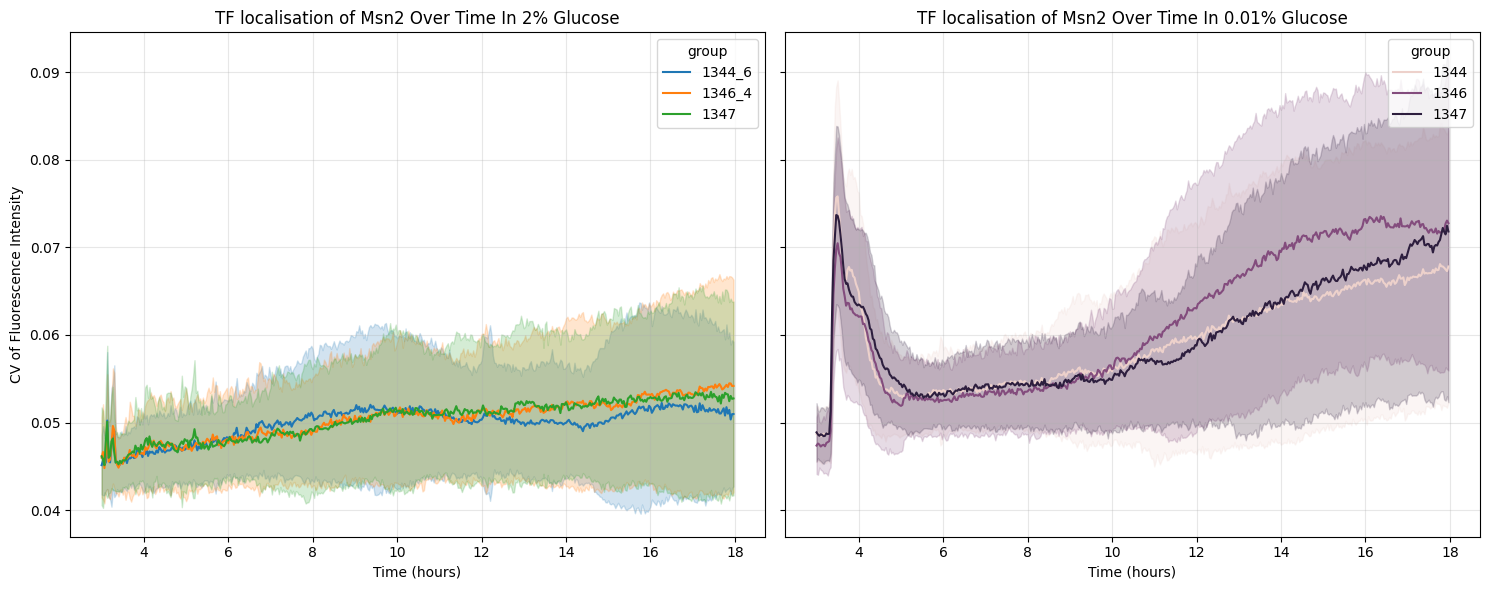

In [56]:
# Plot the 2 df in 2 subplots side by side for comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# Plot for 2% glucose
sns.lineplot(data=df_1, x='time', y=column_name, hue='group', errorbar='sd', ax=axes[0])
axes[0].set_title(f'TF localisation of {tf.values[0]} Over Time In 2% Glucose')
axes[0].set_xlabel('Time (hours)')
axes[0].set_ylabel(f'CV of Fluorescence Intensity')
axes[0].grid(True, alpha=0.3)

# Plot for 0.01% glucose
sns.lineplot(data=df_2, x='time', y=column_name, hue='group', errorbar='sd', ax=axes[1])
axes[1].set_title(f'TF localisation of {tf.values[0]} Over Time In 0.01% Glucose')
axes[1].set_xlabel('Time (hours)')
axes[1].set_ylabel(f'CV of Fluorescence Intensity')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## A 3rd Experiment

=== EXPERIMENT SUMMARY ===

📸 IMAGING SETUP (from acquisition file):
• Channels: ['Brightfield', 'GFP', 'mCherry']
• Exposure times: [30, 30, 100] ms
• Camera EM gain: 270

⏱️ TIME-LAPSE SETTINGS:
• Time interval: 120 seconds (2.0 minutes)
• Number of timepoints: 540
• Total experiment time: 64800 seconds (18.0 hours)

🧪 MICROFLUIDICS SETUP:
• Number of pumps: 2
• Pump rates: [[0.0], [4.0]]
• Pump contents: ['2% glucose in SC', '0.1% glucose in SC']
• Number of switches: 1
• Switch volumes: 50
• Switch rates: 100
• Switch times: [180]

🔬 MICROSCOPE SETUP (from log file):
• Microscope: Batgirl
• Date: 2020-12-06 00:00:00
• Experiment start time: 2020-12-06 22:30:45
• Capture of the first image: 2020-12-06 22:30:47
• MultiDGUI commit: 29bfe736500ed3f8be9c19585bee78cc67ceae26
• Experimental details: Aim:   Strain:   Comments:

💾 OMERO INFORMATION:
• Project: SteadystateGlucose
• Tags: ['06-Dec-2020', 'Batgirl', 'GFP', 'mCherry', '3 chamber', 'Kevin', '1346?_Nrg1-Msn2', '1347_Rtg1-Msn2', '

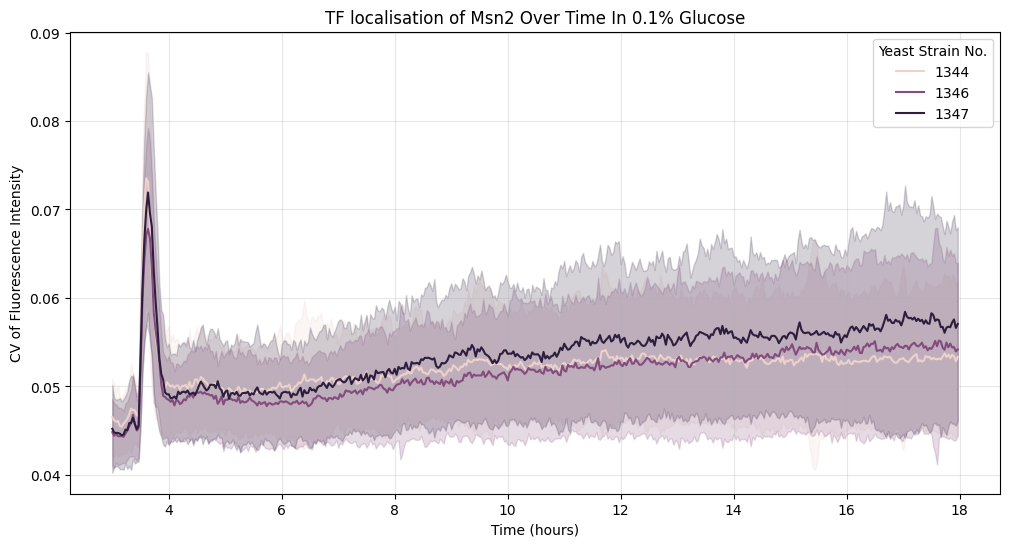

In [59]:
# the acq and log files to get the exp descriptions
acq_file_path = glob.glob(f"/home/ianyang/alibylite/high_quality_data_analysis/{omids[2]}/*Acq.txt")[0]
log_file_path = glob.glob(f"/home/ianyang/alibylite/high_quality_data_analysis/{omids[2]}/*log.txt")[0]
# we only need the tf_df as a variable
_, tf_df, _ = get_exp_summary(acq_file_path, log_file_path)
print(f"Loading data for experiment: {omids[2]}")
# we want the post media switch data
# Note this is not steady state yet...
tsv_path = f"/home/ianyang/stochastic_simulations/experiments/EXP-25-IY010/exp_data/{omids[2]}_post_media_switch.tsv"
column_name = 'CV_mCherry' # change this to 'CV_GFP' for GFP analysis
df_3 = load_tsv(tsv_path)
# group names
group_names = df_3['group'].unique().tolist()
# Convert group_names to strings to match tf_df['group'] data type
group_names_str = [str(g) for g in group_names]

# extract the TF being tracked by using the group_names as index
tf = tf_df.loc[tf_df['group'].isin(group_names_str), 'mCherry TF']
# tf.values[0]

# Plot the required column over time for different groups
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_3, x='time', y=column_name, hue='group', errorbar='sd')
plt.legend(title=f'Yeast Strain No.')
plt.title(f'TF localisation of {tf.values[0]} Over Time In 0.1% Glucose')
plt.xlabel('Time (hours)')
plt.ylabel(f'CV of Fluorescence Intensity')
plt.grid(True, alpha=0.3)
plt.show()

-----------------------------------------------------------

In [60]:
# get the CV_mCherry, group, time and id columns
df_1 = df_1[['CV_mCherry', 'group', 'time', 'id']]
df_2 = df_2[['CV_mCherry', 'group', 'time', 'id']]
df_3 = df_3[['CV_mCherry', 'group', 'time', 'id']]

# Process df_1 and df_2 data to create time series format
print("Processing data transformation...")

def create_time_series_dataframes(df, experiment_name):
    """
    Transform dataframe to time series format where:
    - Each row is a unique id (time series)
    - Each column is a time point
    - Values are CV_mCherry measurements
    """
    time_series_dfs = {}
    groups = df['group'].unique()
    
    print(f"\nProcessing {experiment_name}:")
    print(f"Found {len(groups)} groups: {groups}")
    
    for group in groups:
        print(f"  Processing group {group}...")
        
        # Filter data for this group
        group_data = df[df['group'] == group].copy()
        
        # Get unique ids and time points for this group
        unique_ids = group_data['id'].unique()
        time_points = sorted(group_data['time'].unique())
        
        print(f"    Group {group}: {len(unique_ids)} unique IDs, {len(time_points)} time points")
        
        # Create pivot table: rows=id, columns=time, values=CV_mCherry
        pivot_df = group_data.pivot(index='id', columns='time', values='CV_mCherry')
        
        # Reset index to make 'id' a regular column
        pivot_df = pivot_df.reset_index()
        
        # Add metadata columns
        pivot_df['group'] = group
        pivot_df['experiment'] = experiment_name
        
        # Reorder columns: metadata first, then time points
        metadata_cols = ['id', 'group', 'experiment']
        time_cols = [col for col in pivot_df.columns if col not in metadata_cols]
        pivot_df = pivot_df[metadata_cols + sorted(time_cols)]
        
        # Store in dictionary
        time_series_dfs[f'group_{group}'] = pivot_df
        
        print(f"    Created dataframe shape: {pivot_df.shape}")
        print(f"    Time range: {min(time_cols):.2f} to {max(time_cols):.2f}")
        print(f"    Missing values: {pivot_df.isnull().sum().sum()}")
    
    return time_series_dfs

# Process both experiments
exp1_time_series = create_time_series_dataframes(df_1, omids[0])
exp2_time_series = create_time_series_dataframes(df_2, omids[1])
exp3_time_series = create_time_series_dataframes(df_3, omids[2])

print(f"\n" + "="*60)
print("DATA TRANSFORMATION SUMMARY")
print("="*60)
print(f"Experiment 1 ({omids[0][:30]}...):")
for key, df in exp1_time_series.items():
    print(f"  {key}: {df.shape[0]} time series x {df.shape[1]-3} time points")

print(f"\nExperiment 2 ({omids[1][:30]}...):")
for key, df in exp2_time_series.items():
    print(f"  {key}: {df.shape[0]} time series x {df.shape[1]-3} time points")

print(f"\nExperiment 3 ({omids[2][:30]}...):")
for key, df in exp3_time_series.items():
    print(f"  {key}: {df.shape[0]} time series x {df.shape[1]-3} time points")

Processing data transformation...

Processing 19316_2020_10_26_steadystate_glucose_144m_2w2_00:
Found 3 groups: ['1344_6' '1346_4' '1347']
  Processing group 1344_6...
    Group 1344_6: 71 unique IDs, 450 time points
    Created dataframe shape: (71, 453)
    Time range: 3.00 to 17.97
    Missing values: 298
  Processing group 1346_4...
    Group 1346_4: 84 unique IDs, 450 time points
    Created dataframe shape: (84, 453)
    Time range: 3.00 to 17.97
    Missing values: 387
  Processing group 1347...
    Group 1347: 78 unique IDs, 450 time points
    Created dataframe shape: (78, 453)
    Time range: 3.00 to 17.97
    Missing values: 391

Processing 20213_2021_09_07_steady_0p01glc_1344_1346_1347_00:
Found 3 groups: [1344 1346 1347]
  Processing group 1344...
    Group 1344: 241 unique IDs, 450 time points
    Created dataframe shape: (241, 453)
    Time range: 3.00 to 17.97
    Missing values: 179
  Processing group 1346...
    Group 1346: 231 unique IDs, 450 time points
    Created 

In [61]:
# since the number of time series in each group is different, we will take the minimum number of time series across all groups for training
min_series_exp1 = min(df.shape[0] for df in exp1_time_series.values())
min_series_exp2 = min(df.shape[0] for df in exp2_time_series.values())
min_series_exp3 = min(df.shape[0] for df in exp3_time_series.values())

# the min across all experiments
min_series = min(min_series_exp1, min_series_exp2, min_series_exp3)

# take out the first however many time series from each group to make them balanced
exp1_time_series_balanced = {k: df.iloc[:min_series] for k, df in exp1_time_series.items()}
exp2_time_series_balanced = {k: df.iloc[:min_series] for k, df in exp2_time_series.items()}
exp3_time_series_balanced = {k: df.iloc[:min_series] for k, df in exp3_time_series.items()}

In [ ]:
# Display sample of transformed data
print("SAMPLE OF TRANSFORMED DATA")
print("="*50)
# Use a balanced dataset
# Show first group from each experiment
if exp1_time_series_balanced:
    first_group_exp1 = list(exp1_time_series_balanced.keys())[0]
    sample_df1 = exp1_time_series_balanced[first_group_exp1]
    print(f"\nExperiment 1 - {first_group_exp1}:")
    print(f"Shape: {sample_df1.shape}")
    print("First 5 rows and first 8 columns:")
    display_cols = sample_df1.columns[:8]  # Show first 8 columns (3 metadata + 5 time points)
    print(sample_df1[display_cols].head())

if exp2_time_series_balanced:
    first_group_exp2 = list(exp2_time_series_balanced.keys())[0]
    sample_df2 = exp2_time_series_balanced[first_group_exp2]
    print(f"\nExperiment 2 - {first_group_exp2}:")
    print(f"Shape: {sample_df2.shape}")
    print("First 5 rows and first 8 columns:")
    display_cols = sample_df2.columns[:8]  # Show first 8 columns (3 metadata + 5 time points)
    print(sample_df2[display_cols].head())

if exp3_time_series_balanced:
    first_group_exp3 = list(exp3_time_series_balanced.keys())[0]
    sample_df3 = exp3_time_series_balanced[first_group_exp3]
    print(f"\nExperiment 3 - {first_group_exp3}:")
    print(f"Shape: {sample_df3.shape}")
    print("First 5 rows and first 8 columns:")
    display_cols = sample_df3.columns[:8]  # Show first 8 columns (3 metadata + 5 time points)
    print(sample_df3[display_cols].head())

SAMPLE OF TRANSFORMED DATA

Experiment 1 - group_1344_6:
Shape: (71, 453)
First 5 rows and first 8 columns:
time               id   group  \
0      1344_6_001;0;3  1344_6   
1     1344_6_001;12;1  1344_6   
2     1344_6_001;23;1  1344_6   
3     1344_6_001;29;2  1344_6   
4     1344_6_001;37;1  1344_6   

time                                        experiment       3.0  3.033333  \
0     19316_2020_10_26_steadystate_glucose_144m_2w2_00  0.043222  0.042479   
1     19316_2020_10_26_steadystate_glucose_144m_2w2_00  0.051498  0.049248   
2     19316_2020_10_26_steadystate_glucose_144m_2w2_00  0.045216  0.044756   
3     19316_2020_10_26_steadystate_glucose_144m_2w2_00  0.040811  0.041997   
4     19316_2020_10_26_steadystate_glucose_144m_2w2_00  0.045144  0.046177   

time  3.066667       3.1  3.133333  
0     0.043185  0.042805  0.049842  
1     0.048901  0.048277  0.061837  
2     0.044697  0.044308  0.045096  
3     0.041149  0.044029  0.045195  
4     0.046874  0.054740  0.071933  

E

In [79]:
# Display sample of transformed data
print("SAMPLE OF TRANSFORMED DATA")
print("="*50)

# Show first group from each experiment
if exp1_time_series:
    first_group_exp1 = list(exp1_time_series.keys())[0]
    sample_df1 = exp1_time_series[first_group_exp1]
    print(f"\nExperiment 1 - {first_group_exp1}:")
    print(f"Shape: {sample_df1.shape}")
    print("First 5 rows and first 8 columns:")
    display_cols = sample_df1.columns[:8]  # Show first 8 columns (3 metadata + 5 time points)
    print(sample_df1[display_cols].head())

if exp2_time_series:
    first_group_exp2 = list(exp2_time_series.keys())[0]
    sample_df2 = exp2_time_series[first_group_exp2]
    print(f"\nExperiment 2 - {first_group_exp2}:")
    print(f"Shape: {sample_df2.shape}")
    print("First 5 rows and first 8 columns:")
    display_cols = sample_df2.columns[:8]  # Show first 8 columns (3 metadata + 5 time points)
    print(sample_df2[display_cols].head())

if exp3_time_series:
    first_group_exp3 = list(exp3_time_series.keys())[0]
    sample_df3 = exp3_time_series[first_group_exp3]
    print(f"\nExperiment 3 - {first_group_exp3}:")
    print(f"Shape: {sample_df3.shape}")
    print("First 5 rows and first 8 columns:")
    display_cols = sample_df3.columns[:8]  # Show first 8 columns (3 metadata + 5 time points)
    print(sample_df3[display_cols].head())

SAMPLE OF TRANSFORMED DATA

Experiment 1 - group_1344_6:
Shape: (71, 453)
First 5 rows and first 8 columns:
time               id   group  \
0      1344_6_001;0;3  1344_6   
1     1344_6_001;12;1  1344_6   
2     1344_6_001;23;1  1344_6   
3     1344_6_001;29;2  1344_6   
4     1344_6_001;37;1  1344_6   

time                                        experiment       3.0  3.033333  \
0     19316_2020_10_26_steadystate_glucose_144m_2w2_00  0.043222  0.042479   
1     19316_2020_10_26_steadystate_glucose_144m_2w2_00  0.051498  0.049248   
2     19316_2020_10_26_steadystate_glucose_144m_2w2_00  0.045216  0.044756   
3     19316_2020_10_26_steadystate_glucose_144m_2w2_00  0.040811  0.041997   
4     19316_2020_10_26_steadystate_glucose_144m_2w2_00  0.045144  0.046177   

time  3.066667       3.1  3.133333  
0     0.043185  0.042805  0.049842  
1     0.048901  0.048277  0.061837  
2     0.044697  0.044308  0.045096  
3     0.041149  0.044029  0.045195  
4     0.046874  0.054740  0.071933  

E

TIME SERIES VISUALIZATION


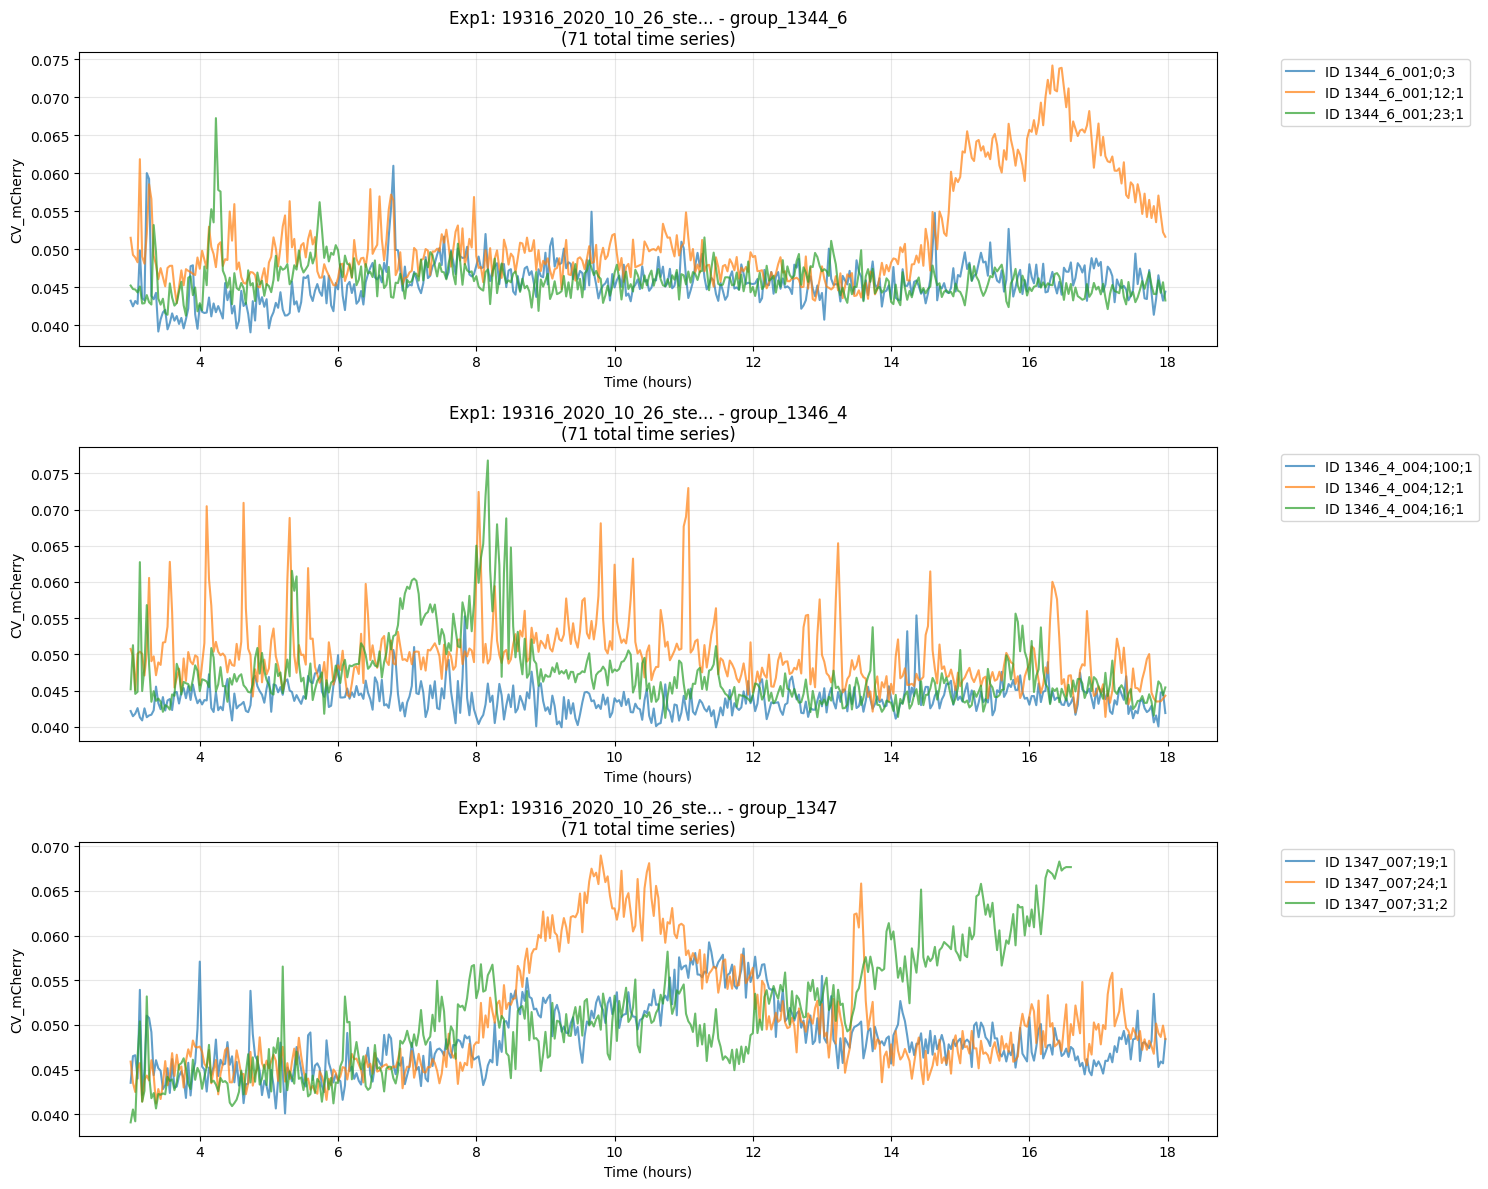

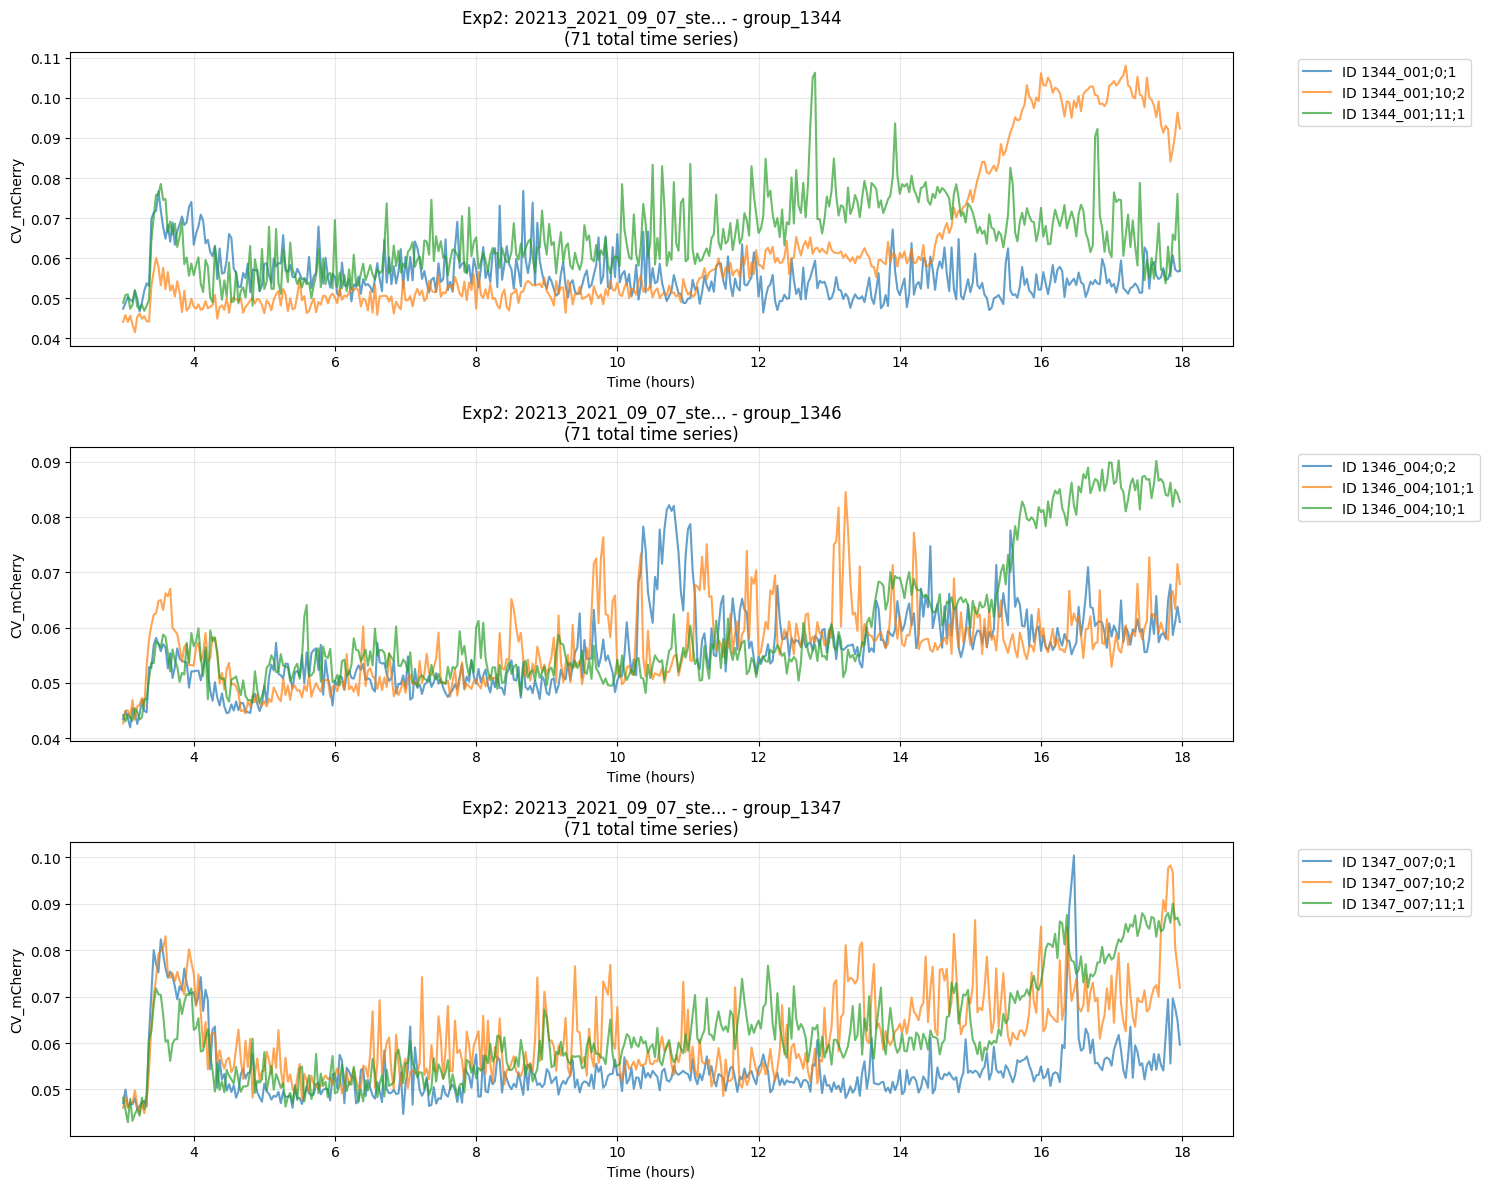

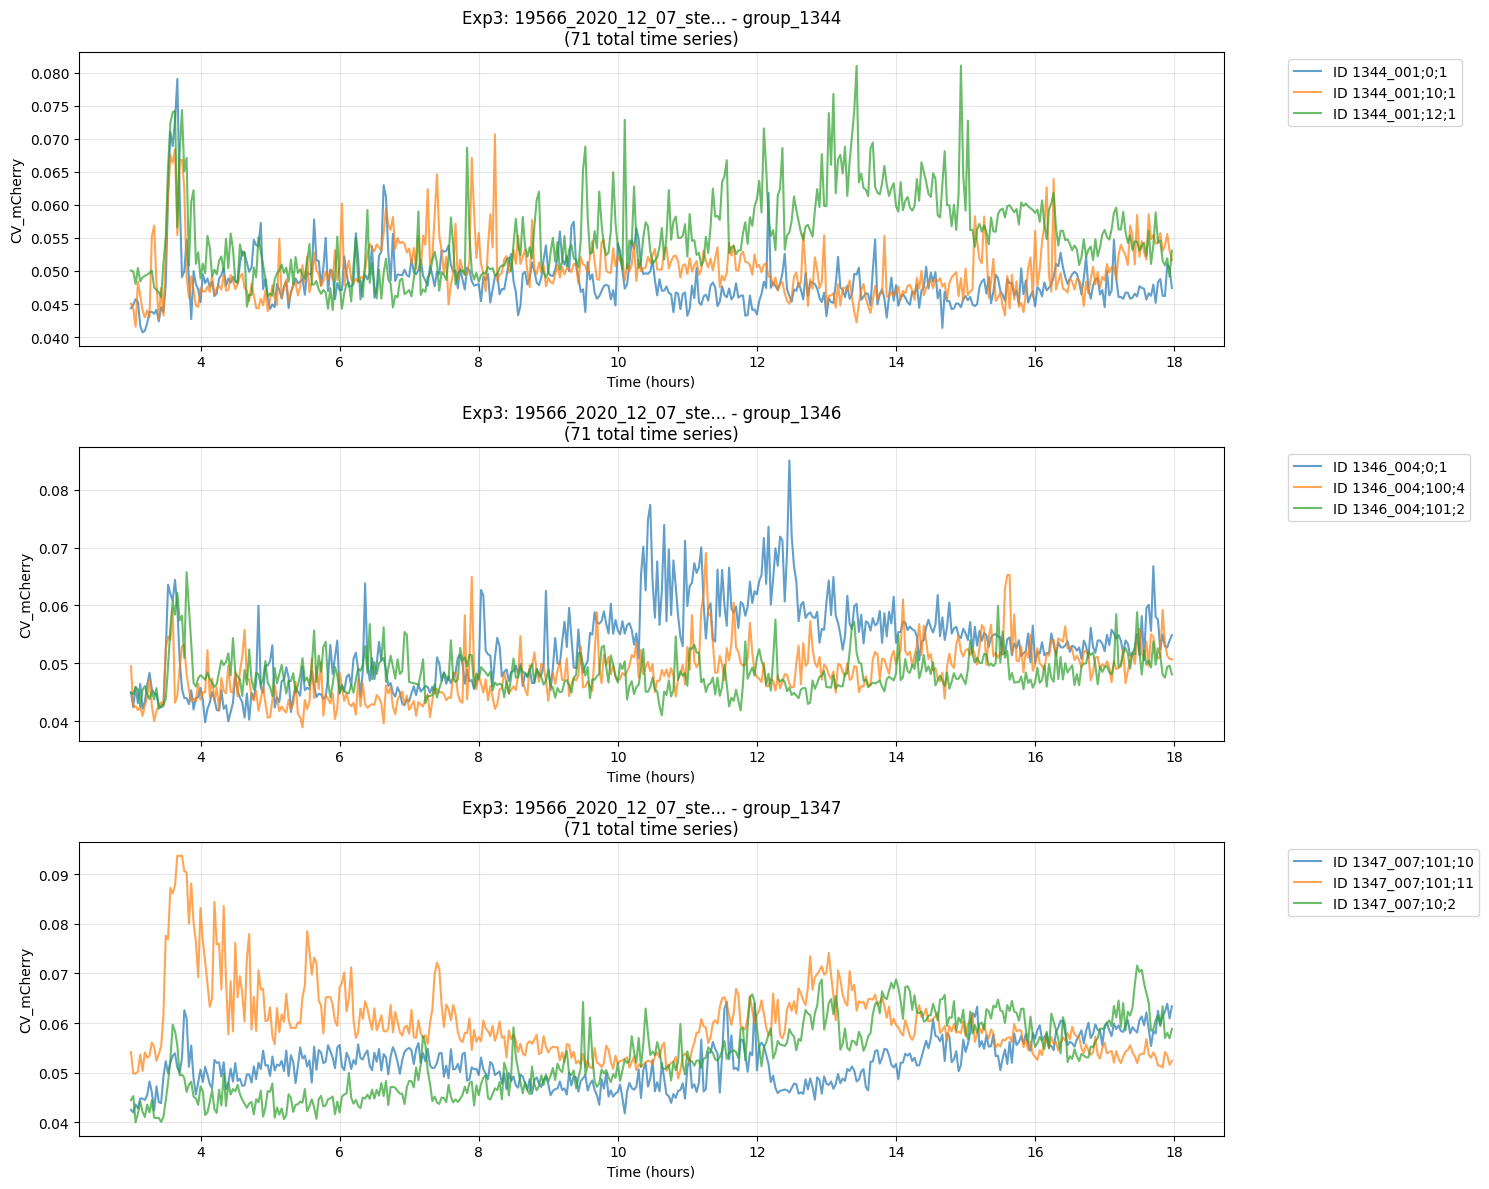

In [63]:
# Visualize the time series data structure
import matplotlib.pyplot as plt
import seaborn as sns

def plot_time_series_overview(time_series_dict, experiment_name, max_series=5):
    """Plot overview of time series data for each group"""
    
    fig, axes = plt.subplots(len(time_series_dict), 1, figsize=(15, 4*len(time_series_dict)))
    if len(time_series_dict) == 1:
        axes = [axes]
    
    for idx, (group_name, df) in enumerate(time_series_dict.items()):
        ax = axes[idx]
        
        # Get time columns (exclude metadata columns)
        time_cols = [col for col in df.columns if col not in ['id', 'group', 'experiment']]
        time_values = [float(col) for col in time_cols]
        
        # Plot first few time series
        n_series = min(max_series, len(df))
        for i in range(n_series):
            cv_values = df.iloc[i][time_cols].values
            # Only plot non-NaN values
            valid_mask = ~pd.isna(cv_values)
            if valid_mask.any():
                ax.plot([time_values[j] for j in range(len(time_values)) if valid_mask[j]], 
                       cv_values[valid_mask], alpha=0.7, label=f'ID {df.iloc[i]["id"]}')
        
        ax.set_title(f'{experiment_name} - {group_name}\n({len(df)} total time series)')
        ax.set_xlabel('Time (hours)')
        ax.set_ylabel('CV_mCherry')
        ax.grid(True, alpha=0.3)
        if n_series <= 10:  # Only show legend if not too many series
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot overview for both experiments
print("TIME SERIES VISUALIZATION")
print("="*50)

plot_time_series_overview(exp1_time_series_balanced, f"Exp1: {omids[0][:20]}...", max_series=3)
plot_time_series_overview(exp2_time_series_balanced, f"Exp2: {omids[1][:20]}...", max_series=3)
plot_time_series_overview(exp3_time_series_balanced, f"Exp3: {omids[2][:20]}...", max_series=3)

In [64]:
# Check data quality and completeness
print("DATA QUALITY ANALYSIS")
print("="*50)

def analyze_data_quality(time_series_dict, experiment_name):
    """Analyze completeness and quality of time series data"""
    
    print(f"\n{experiment_name}:")
    
    for group_name, df in time_series_dict.items():
        print(f"\n  {group_name}:")
        
        # Get time columns
        time_cols = [col for col in df.columns if col not in ['id', 'group', 'experiment']]
        
        # Calculate statistics
        total_values = len(df) * len(time_cols)
        missing_values = df[time_cols].isnull().sum().sum()
        completeness = (total_values - missing_values) / total_values * 100

        # Time series length statistics
        series_lengths = []
        for idx, row in df.iterrows():
            valid_count = row[time_cols].notna().sum()
            series_lengths.append(valid_count)
        
        print(f"    Total time series: {len(df)}")
        print(f"    Time points per series: {len(time_cols)}")
        print(f"    Data completeness: {completeness:.1f}%")
        print(f"    Series length stats:")
        print(f"      Min: {min(series_lengths)} points")
        print(f"      Max: {max(series_lengths)} points") 
        print(f"      Mean: {np.mean(series_lengths):.1f} points")
        print(f"      Std: {np.std(series_lengths):.1f} points")
        
        # Value range statistics
        all_values = df[time_cols].values.flatten()
        all_values = all_values[~pd.isna(all_values)]
        
        print(f"    CV_mCherry value stats:")
        print(f"      Min: {np.min(all_values):.3f}")
        print(f"      Max: {np.max(all_values):.3f}")
        print(f"      Mean: {np.mean(all_values):.3f}")
        print(f"      Std: {np.std(all_values):.3f}")

analyze_data_quality(exp1_time_series_balanced, f"Experiment 1 ({omids[0][:30]}...)")
analyze_data_quality(exp2_time_series_balanced, f"Experiment 2 ({omids[1][:30]}...)")
analyze_data_quality(exp3_time_series_balanced, f"Experiment 3 ({omids[2][:30]}...)")

DATA QUALITY ANALYSIS

Experiment 1 (19316_2020_10_26_steadystate_g...):

  group_1344_6:
    Total time series: 71
    Time points per series: 450
    Data completeness: 99.1%
    Series length stats:
      Min: 400 points
      Max: 450 points
      Mean: 445.8 points
      Std: 10.6 points
    CV_mCherry value stats:
      Min: 0.035
      Max: 0.129
      Mean: 0.050
      Std: 0.008

  group_1346_4:
    Total time series: 71
    Time points per series: 450
    Data completeness: 98.9%
    Series length stats:
      Min: 402 points
      Max: 450 points
      Mean: 445.0 points
      Std: 10.4 points
    CV_mCherry value stats:
      Min: 0.031
      Max: 0.110
      Mean: 0.050
      Std: 0.008

  group_1347:
    Total time series: 71
    Time points per series: 450
    Data completeness: 98.8%
    Series length stats:
      Min: 404 points
      Max: 450 points
      Mean: 444.6 points
      Std: 11.0 points
    CV_mCherry value stats:
      Min: 0.037
      Max: 0.111
      Mean

In [80]:
# Save the transformed data
print("SAVING TRANSFORMED DATA")
print("="*30)

import os

# Create output directory
output_dir = "transformed_exp_time_series_data"
os.makedirs(output_dir, exist_ok=True)

# Save each group's data as separate CSV files
def save_time_series_data(time_series_dict, experiment_name, output_dir):
    """Save each group's time series data to CSV files"""
    
    saved_files = []
    
    for group_name, df in time_series_dict.items():
        # Create filename
        filename = f"{experiment_name}_{group_name}_time_series.csv"
        filepath = os.path.join(output_dir, filename)
        
        # Save to CSV
        df.to_csv(filepath, index=False)
        saved_files.append(filepath)
        
        print(f"Saved: {filename} ({df.shape[0]} x {df.shape[1]})")
    
    return saved_files

# Save data for both experiments
exp1_files = save_time_series_data(exp1_time_series, omids[0], output_dir)
exp2_files = save_time_series_data(exp2_time_series, omids[1], output_dir)
exp3_files = save_time_series_data(exp3_time_series, omids[2], output_dir)

# balancely labelled data
# exp1_files = save_time_series_data(exp1_time_series_balanced, omids[0], output_dir)
# exp2_files = save_time_series_data(exp2_time_series_balanced, omids[1], output_dir)
# exp3_files = save_time_series_data(exp3_time_series_balanced, omids[2], output_dir)

print(f"\nAll files saved to: {output_dir}/")
print(f"Total files created: {len(exp1_files) + len(exp2_files) + len(exp3_files)}")

SAVING TRANSFORMED DATA
Saved: 19316_2020_10_26_steadystate_glucose_144m_2w2_00_group_1344_6_time_series.csv (71 x 453)
Saved: 19316_2020_10_26_steadystate_glucose_144m_2w2_00_group_1346_4_time_series.csv (84 x 453)
Saved: 19316_2020_10_26_steadystate_glucose_144m_2w2_00_group_1347_time_series.csv (78 x 453)
Saved: 20213_2021_09_07_steady_0p01glc_1344_1346_1347_00_group_1344_time_series.csv (241 x 453)
Saved: 20213_2021_09_07_steady_0p01glc_1344_1346_1347_00_group_1346_time_series.csv (231 x 453)
Saved: 20213_2021_09_07_steady_0p01glc_1344_1346_1347_00_group_1347_time_series.csv (275 x 453)
Saved: 19566_2020_12_07_steadystate_glucose_1344m_2w0p1_01_group_1344_time_series.csv (214 x 453)
Saved: 20213_2021_09_07_steady_0p01glc_1344_1346_1347_00_group_1346_time_series.csv (231 x 453)
Saved: 20213_2021_09_07_steady_0p01glc_1344_1346_1347_00_group_1347_time_series.csv (275 x 453)
Saved: 19566_2020_12_07_steadystate_glucose_1344m_2w0p1_01_group_1344_time_series.csv (214 x 453)
Saved: 19566_2

In [81]:
# Create a combined dataset for machine learning (optional)
print("CREATING COMBINED DATASET FOR ML")
print("="*40)

def create_ml_dataset(exp1_dict, exp2_dict):
    """Combine data from both experiments for machine learning"""
    
    all_time_series = []
    all_labels = []
    all_metadata = []
    
    # Process experiment 1 (label = 0)
    for group_name, df in exp1_dict.items():
        time_cols = [col for col in df.columns if col not in ['id', 'group', 'experiment']]
        
        for idx, row in df.iterrows():
            # Get the time series values
            series_values = row[time_cols].values
            
            # Only include series with sufficient data (at least 50% non-NaN)
            valid_ratio = np.sum(~pd.isna(series_values)) / len(series_values)
            if valid_ratio >= 0.5:  # At least 50% valid data
                all_time_series.append(series_values)
                all_labels.append(0)  # Experiment 1 = label 0
                all_metadata.append({
                    'experiment': row['experiment'],
                    'group': row['group'],
                    'id': row['id'],
                    'valid_ratio': valid_ratio
                })
    
    # Process experiment 2 (label = 1)
    for group_name, df in exp2_dict.items():
        time_cols = [col for col in df.columns if col not in ['id', 'group', 'experiment']]
        
        for idx, row in df.iterrows():
            # Get the time series values
            series_values = row[time_cols].values
            
            # Only include series with sufficient data
            valid_ratio = np.sum(~pd.isna(series_values)) / len(series_values)
            if valid_ratio >= 0.5:
                all_time_series.append(series_values)
                all_labels.append(1)  # Experiment 2 = label 1
                all_metadata.append({
                    'experiment': row['experiment'],
                    'group': row['group'], 
                    'id': row['id'],
                    'valid_ratio': valid_ratio
                })
    
    return all_time_series, all_labels, all_metadata

# Create combined dataset
combined_series_1_2, combined_labels_1_2, combined_metadata_1_2 = create_ml_dataset(exp1_time_series, exp2_time_series)
# combine 1 with 3
combined_series_1_3, combined_labels_1_3, combined_metadata_1_3 = create_ml_dataset(exp1_time_series, exp3_time_series)
# combine 2 with 3
combined_series_2_3, combined_labels_2_3, combined_metadata_2_3 = create_ml_dataset(exp2_time_series, exp3_time_series)

# # balancedly labelled data
# combined_series_1_2, combined_labels_1_2, combined_metadata_1_2 = create_ml_dataset(exp1_time_series_balanced, exp2_time_series_balanced)
# # combine 1 with 3
# combined_series_1_3, combined_labels_1_3, combined_metadata_1_3 = create_ml_dataset(exp1_time_series_balanced, exp3_time_series_balanced)
# # combine 2 with 3
# combined_series_2_3, combined_labels_2_3, combined_metadata_2_3 = create_ml_dataset(exp2_time_series_balanced, exp3_time_series_balanced)



CREATING COMBINED DATASET FOR ML


In [85]:
# Choose which combination to use
combined_series = combined_series_1_3  # Change to _1_3 or _2_3 as needed
combined_labels = combined_labels_1_3
combined_metadata = combined_metadata_1_3

print(f"Combined dataset created:")
print(f"  Total time series: {len(combined_series)}")
print(f"  Label distribution: {np.bincount(combined_labels)}")
print(f"  Experiment 1 (label 0): {np.sum(np.array(combined_labels) == 0)} series")
print(f"  Experiment 2 (label 1): {np.sum(np.array(combined_labels) == 1)} series")

# Show sample metadata
metadata_df = pd.DataFrame(combined_metadata)
print(f"\nMetadata summary:")
print(metadata_df.groupby(['experiment', 'group']).size().to_string())
print(f"\nValid data ratio statistics:")
print(f"  Mean: {metadata_df['valid_ratio'].mean():.3f}")
print(f"  Min: {metadata_df['valid_ratio'].min():.3f}")
print(f"  Max: {metadata_df['valid_ratio'].max():.3f}")

Combined dataset created:
  Total time series: 878
  Label distribution: [233 645]
  Experiment 1 (label 0): 233 series
  Experiment 2 (label 1): 645 series

Metadata summary:
experiment                                           group 
19316_2020_10_26_steadystate_glucose_144m_2w2_00     1344_6     71
                                                     1346_4     84
                                                     1347       78
19566_2020_12_07_steadystate_glucose_1344m_2w0p1_01  1344      214
                                                     1346      231
                                                     1347      200

Valid data ratio statistics:
  Mean: 0.995
  Min: 0.882
  Max: 1.000


## Machine Learning / Deep Learning

In [86]:
# Import custom classifiers from the codebase
import sys
from pathlib import Path

# Ensure the src directory is on the Python path
sys.path.append(str(Path("/home/ianyang/stochastic_simulations/src").resolve()))
# from classifiers.svm_classifier import svm_classifier
################## MANUALLY IMPORTING THIS FUNCTION AS THE CALL DIDNT WORK! #######################
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
import pandas as pd
from typing import Dict, Optional


def svm_classifier(X_train, X_test, y_train, y_test, 
                   svm_C=1.0, 
                   svm_gamma='scale', 
                   svm_kernel='rbf',
                   print_classification_report=False,
                   print_confusion_matrix=False,
                   ):
    """
    Trains a basic SVM model for classification and evaluates the model.
    
    Parameters:
        X_train, X_test, y_train, y_test: Split data
        svm_C: Regularization parameter (default: 1.0)
        svm_gamma: Kernel coefficient for 'rbf', 'poly', and 'sigmoid' (default: 'scale') 
        svm_kernel: Specifies the kernel type to be used in the algorithm (default: 'rbf')
    
    Returns:
        accuracy: Classification accuracy of the SVM
    
    Example:
        >>> from sklearn.datasets import make_classification
        >>> from sklearn.model_selection import train_test_split
        >>> X, y = make_classification(n_samples=100, n_features=4, n_classes=2, random_state=42)
        >>> X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        >>> accuracy = svm_classifier(X_train, X_test, y_train, y_test, svm_C=1.0, svm_kernel='rbf')
        === SVM (RBF Kernel) Classification Accuracy: 0.87 ===
        >>> print(f"Accuracy: {accuracy}")
        Accuracy: 0.87
    """
    # Train a basic SVM model without grid search
    svm_model = SVC(C=svm_C, gamma=svm_gamma, kernel=svm_kernel)
    svm_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = svm_model.predict(X_test)
    svm_acc = accuracy_score(y_test, y_pred)
    if svm_kernel == 'rbf':
        print(f"=== SVM (RBF Kernel) Classification Accuracy: {svm_acc:.2f} ===")
    elif svm_kernel == 'linear':
        print(f"=== SVM (Linear Kernel) Classification Accuracy: {svm_acc:.2f} ===")

    if print_classification_report:
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

    if print_confusion_matrix:
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

    return svm_acc
################## MANUALLY IMPORTING THIS FUNCTION AS THE CALL DIDNT WORK! #######################

from classifiers.lstm_classifier import lstm_classifier
from classifiers.transformer_classifier import transformer_classifier

print("Custom classifiers imported successfully!")

Custom classifiers imported successfully!


## Handle Missing Data

In [87]:
# Prepare data for custom classifiers
print("PREPARING DATA FOR CUSTOM CLASSIFIERS")
print("="*50)

# Handle missing values in the combined dataset
def handle_missing_values(time_series_list):
    """Handle missing values by interpolation or forward fill"""
    processed_series = []
    
    for series in time_series_list:
        # Convert to pandas Series for easier handling
        s = pd.Series(series)
        
        # Interpolate missing values
        s = s.interpolate(method='linear', limit_direction='both')
        
        # If still NaN (e.g., all NaN), forward fill
        s = s.fillna(method='ffill').fillna(method='bfill')
        
        # If still NaN, fill with mean of non-NaN values from other series
        if s.isnull().any():
            global_mean = np.nanmean([np.nanmean(ts) for ts in time_series_list])
            s = s.fillna(global_mean)
        
        processed_series.append(s.values)
    
    return processed_series

# Process the combined series to handle missing values
processed_series = handle_missing_values(combined_series)

# Convert to numpy array and determine common length
series_lengths = [len(series) for series in processed_series]
common_length = int(np.percentile(series_lengths, 75))  # Use 75th percentile

print(f"Series length statistics:")
print(f"  Min: {min(series_lengths)}, Max: {max(series_lengths)}")
print(f"  Mean: {np.mean(series_lengths):.1f}, Std: {np.std(series_lengths):.1f}")
print(f"  Using common length: {common_length}")

# Prepare final dataset
def prepare_final_dataset(series_list, labels_list, target_length):
    """Prepare final dataset with consistent length"""
    X = []
    y = []
    
    for series, label in zip(series_list, labels_list):
        if len(series) >= target_length:
            # Truncate to target length
            X.append(series[:target_length])
        else:
            # Pad with the last value
            padded = np.pad(series, (0, target_length - len(series)), 
                          mode='edge')
            X.append(padded)
        y.append(label)
    
    return np.array(X), np.array(y)

# Create final dataset
X_final, y_final = prepare_final_dataset(processed_series, combined_labels, common_length)

print(f"\nFinal dataset shape: X={X_final.shape}, y={y_final.shape}")
print(f"Label distribution: {np.bincount(y_final)}")
print(f"Data range: [{X_final.min():.3f}, {X_final.max():.3f}]")

# Check for any remaining NaN values
if np.isnan(X_final).any():
    print(f"⚠️  Warning: {np.isnan(X_final).sum()} NaN values still present")
    # Fill any remaining NaN with global mean
    X_final = np.nan_to_num(X_final, nan=np.nanmean(X_final))
    print("  Replaced NaN values with global mean")

print("✅ Data preparation complete!")

PREPARING DATA FOR CUSTOM CLASSIFIERS
Series length statistics:
  Min: 450, Max: 450
  Mean: 450.0, Std: 0.0
  Using common length: 450

Final dataset shape: X=(878, 450), y=(878,)
Label distribution: [233 645]
Data range: [0.031, 0.206]
✅ Data preparation complete!


## Dataset splitting & classification

In [88]:
# Split data for custom classifiers
print("SPLITTING DATA FOR CUSTOM CLASSIFIERS")
print("="*45)

# Split into train/validation/test sets
X_temp, X_test_custom, y_temp, y_test_custom = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)
X_train_custom, X_val_custom, y_train_custom, y_val_custom = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Data split for custom classifiers:")
print(f"  Training: {X_train_custom.shape[0]} samples")
print(f"  Validation: {X_val_custom.shape[0]} samples")
print(f"  Test: {X_test_custom.shape[0]} samples")
print(f"  Training label distribution: {np.bincount(y_train_custom)}")
print(f"  Validation label distribution: {np.bincount(y_val_custom)}")
print(f"  Test label distribution: {np.bincount(y_test_custom)}")

# Run custom classifiers
print("\n" + "="*60)
print("RUNNING CUSTOM CLASSIFIERS")
print("="*60)

# 1. SVM Classifier
print("\n🔧 Running SVM Classifier...")
svm_rbf_accuracy = svm_classifier(X_train_custom, X_test_custom, y_train_custom, y_test_custom)
print(f"✅ SVM (RBF) Accuracy: {svm_rbf_accuracy:.4f}")

# 2. LSTM Classifier with advanced features
print("\n🔧 Running LSTM Classifier with advanced features...")
iy001a_lstm_accuracy = lstm_classifier(
    X_train_custom,
    X_val_custom,
    X_test_custom,
    y_train_custom,
    y_val_custom,
    y_test_custom,
    epochs=100,
    hidden_size=128,
    num_layers=4,
    dropout_rate=0.2,
    learning_rate=0.001,
    batch_size=64,
    use_conv1d=True,
    use_attention=True,
    num_attention_heads=4,
    use_auxiliary=True,
)
print(f"✅ Advanced LSTM Accuracy: {iy001a_lstm_accuracy:.4f}")

# 3. Transformer Classifier with advanced features
print("\n🔧 Running Transformer Classifier with advanced features...")
transformer_full_accuracy = transformer_classifier(
    X_train_custom,
    X_val_custom,
    X_test_custom,
    y_train_custom,
    y_val_custom,
    y_test_custom,
    d_model=128,
    nhead=8,
    num_layers=4,
    epochs=50,
    use_conv1d=True,
    use_auxiliary=True,
)
print(f"✅ Advanced Transformer Accuracy: {transformer_full_accuracy:.4f}")

print("\n🎉 All custom classifiers completed successfully!")

SPLITTING DATA FOR CUSTOM CLASSIFIERS
Data split for custom classifiers:
  Training: 526 samples
  Validation: 176 samples
  Test: 176 samples
  Training label distribution: [139 387]
  Validation label distribution: [ 47 129]
  Test label distribution: [ 47 129]

RUNNING CUSTOM CLASSIFIERS

🔧 Running SVM Classifier...
=== SVM (RBF Kernel) Classification Accuracy: 0.94 ===
✅ SVM (RBF) Accuracy: 0.9375

🔧 Running LSTM Classifier with advanced features...
=== LSTM with Conv1D and 4-Head Attention Accuracy: 0.73 ===
✅ Advanced LSTM Accuracy: 0.7330

🔧 Running Transformer Classifier with advanced features...
=== LSTM with Conv1D and 4-Head Attention Accuracy: 0.73 ===
✅ Advanced LSTM Accuracy: 0.7330

🔧 Running Transformer Classifier with advanced features...
=== Transformer with Conv1D and Auxiliary Task Accuracy: 0.73 ===
✅ Advanced Transformer Accuracy: 0.7330

🎉 All custom classifiers completed successfully!
=== Transformer with Conv1D and Auxiliary Task Accuracy: 0.73 ===
✅ Advanced T

COMPREHENSIVE MODEL COMPARISON
🏆 CUSTOM CLASSIFIERS RESULTS:
                      Model  Accuracy                                       Features
           Custom SVM (RBF)  0.937500                 RBF Kernel, Probability Output
       Custom Advanced LSTM  0.732955            Conv1D + Attention + Auxiliary Loss
Custom Advanced Transformer  0.732955 Conv1D + Multi-head Attention + Auxiliary Loss

🥇 BEST PERFORMING MODEL:
   Model: Custom SVM (RBF)
   Accuracy: 0.9375
   Features: RBF Kernel, Probability Output


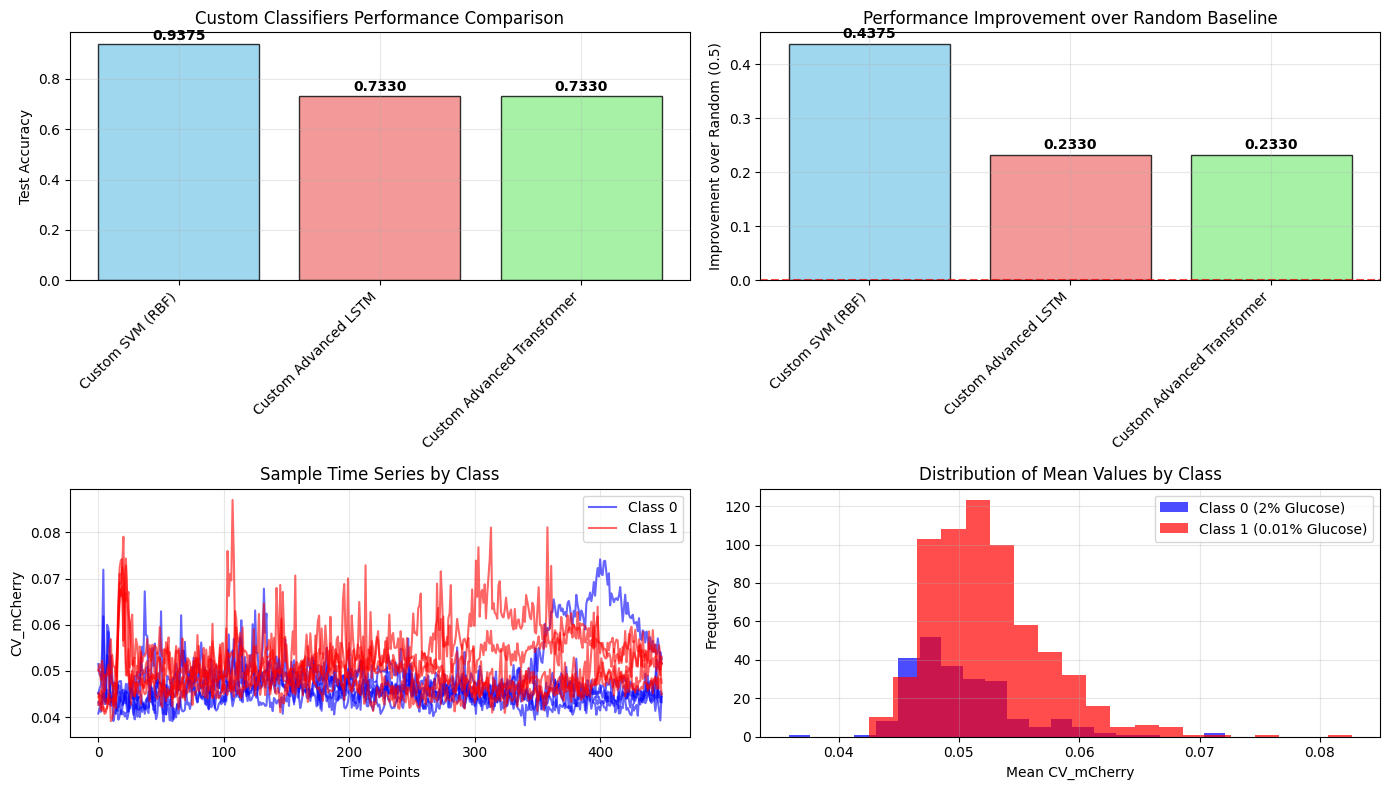


📊 STATISTICAL ANALYSIS:
   Class 0 (2% Glucose) mean CV: 0.050 ± 0.005
   Class 1 (0.01% Glucose) mean CV: 0.052 ± 0.005
   T-test: t=-5.903, p=0.000000
   Statistically significant: Yes (p < 0.05)

🔍 EXPERIMENT SUMMARY:
   Total time series analyzed: 878
   Time series length: 450 time points
   Classes: 2 (glucose conditions)
   Best model achieved 93.8% accuracy


In [89]:
# Compare all classifier results
print("="*70)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*70)

# Create comprehensive results summary
comprehensive_results = pd.DataFrame({
    'Model': [
        'Custom SVM (RBF)',
        'Custom Advanced LSTM', 
        'Custom Advanced Transformer'
    ],
    'Accuracy': [
        svm_rbf_accuracy,
        iy001a_lstm_accuracy,
        transformer_full_accuracy
    ],
    'Features': [
        'RBF Kernel, Probability Output',
        'Conv1D + Attention + Auxiliary Loss',
        'Conv1D + Multi-head Attention + Auxiliary Loss'
    ]
})

print("🏆 CUSTOM CLASSIFIERS RESULTS:")
print(comprehensive_results.to_string(index=False))

# Find best model
best_idx = comprehensive_results['Accuracy'].idxmax()
best_model = comprehensive_results.loc[best_idx, 'Model']
best_accuracy = comprehensive_results.loc[best_idx, 'Accuracy']

print(f"\n🥇 BEST PERFORMING MODEL:")
print(f"   Model: {best_model}")
print(f"   Accuracy: {best_accuracy:.4f}")
print(f"   Features: {comprehensive_results.loc[best_idx, 'Features']}")

# Visualize results
plt.figure(figsize=(14, 8))

# Bar plot of accuracies
plt.subplot(2, 2, 1)
colors = ['skyblue', 'lightcoral', 'lightgreen']
bars = plt.bar(range(len(comprehensive_results)), comprehensive_results['Accuracy'], 
               color=colors, alpha=0.8, edgecolor='black')
plt.xticks(range(len(comprehensive_results)), comprehensive_results['Model'], rotation=45, ha='right')
plt.ylabel('Test Accuracy')
plt.title('Custom Classifiers Performance Comparison')
plt.grid(True, alpha=0.3)

# Add accuracy values on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot difference from random baseline (0.5)
plt.subplot(2, 2, 2)
baseline = 0.5
improvements = comprehensive_results['Accuracy'] - baseline
bars2 = plt.bar(range(len(comprehensive_results)), improvements, 
                color=colors, alpha=0.8, edgecolor='black')
plt.xticks(range(len(comprehensive_results)), comprehensive_results['Model'], rotation=45, ha='right')
plt.ylabel('Improvement over Random (0.5)')
plt.title('Performance Improvement over Random Baseline')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)

# Add improvement values on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# Sample time series from each class
plt.subplot(2, 2, 3)
class_0_indices = np.where(y_final == 0)[0]
class_1_indices = np.where(y_final == 1)[0]

# Plot sample time series
for i in range(min(5, len(class_0_indices))):
    plt.plot(X_final[class_0_indices[i]], alpha=0.6, color='blue', label='Class 0' if i == 0 else "")
for i in range(min(5, len(class_1_indices))):
    plt.plot(X_final[class_1_indices[i]], alpha=0.6, color='red', label='Class 1' if i == 0 else "")

plt.xlabel('Time Points')
plt.ylabel('CV_mCherry')
plt.title('Sample Time Series by Class')
plt.legend()
plt.grid(True, alpha=0.3)

# Data distribution
plt.subplot(2, 2, 4)
class_0_means = [np.mean(X_final[i]) for i in class_0_indices]
class_1_means = [np.mean(X_final[i]) for i in class_1_indices]

plt.hist(class_0_means, alpha=0.7, label='Class 0 (2% Glucose)', bins=20, color='blue')
plt.hist(class_1_means, alpha=0.7, label='Class 1 (0.01% Glucose)', bins=20, color='red')
plt.xlabel('Mean CV_mCherry')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Values by Class')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical significance test
from scipy import stats

print(f"\n📊 STATISTICAL ANALYSIS:")
print(f"   Class 0 (2% Glucose) mean CV: {np.mean(class_0_means):.3f} ± {np.std(class_0_means):.3f}")
print(f"   Class 1 (0.01% Glucose) mean CV: {np.mean(class_1_means):.3f} ± {np.std(class_1_means):.3f}")

# T-test
t_stat, p_value = stats.ttest_ind(class_0_means, class_1_means)
print(f"   T-test: t={t_stat:.3f}, p={p_value:.6f}")
print(f"   Statistically significant: {'Yes' if p_value < 0.05 else 'No'} (p < 0.05)")

print(f"\n🔍 EXPERIMENT SUMMARY:")
print(f"   Total time series analyzed: {len(X_final)}")
print(f"   Time series length: {X_final.shape[1]} time points")
print(f"   Classes: 2 (glucose conditions)")
print(f"   Best model achieved {best_accuracy:.1%} accuracy")

In [90]:
# Save comprehensive results
print("💾 SAVING COMPREHENSIVE RESULTS")
print("="*35)

# Create detailed results dataframe
final_results = pd.DataFrame({
    'Experiment_ID': ['IY010_custom_classifiers'],
    'Experiment_0': [omids[0]],
    'Experiment_1': [omids[1]],
    'Target_Column': ['CV_mCherry'],
    'Total_Time_Series': [len(X_final)],
    'Time_Series_Length': [X_final.shape[1]],
    'Train_Samples': [X_train_custom.shape[0]],
    'Val_Samples': [X_val_custom.shape[0]],
    'Test_Samples': [X_test_custom.shape[0]],
    'Custom_SVM_Accuracy': [svm_rbf_accuracy],
    'Custom_LSTM_Accuracy': [iy001a_lstm_accuracy],
    'Custom_Transformer_Accuracy': [transformer_full_accuracy],
    'Best_Model': [best_model],
    'Best_Accuracy': [best_accuracy],
    'Class_0_Mean_CV': [np.mean(class_0_means)],
    'Class_1_Mean_CV': [np.mean(class_1_means)],
    'T_Test_P_Value': [p_value],
    'Statistically_Significant': [p_value < 0.05]
})

# Save main results
results_file = "IY010_custom_classifiers_results.csv"
final_results.to_csv(results_file, index=False)

# Save detailed model comparison
model_comparison_file = "IY010_model_comparison.csv"
comprehensive_results.to_csv(model_comparison_file, index=False)

# Save time series metadata
metadata_file = "IY010_time_series_metadata.csv"
pd.DataFrame(combined_metadata).to_csv(metadata_file, index=False)

print(f"✅ Results saved:")
print(f"   Main results: {results_file}")
print(f"   Model comparison: {model_comparison_file}")
print(f"   Time series metadata: {metadata_file}")

print(f"\n📋 FINAL SUMMARY:")
print("="*50)
for _, row in final_results.iterrows():
    print(f"🔬 Experiment: {row['Experiment_ID']}")
    print(f"📊 Data: {row['Total_Time_Series']} time series × {row['Time_Series_Length']} time points")
    print(f"🎯 Target: {row['Target_Column']}")
    print(f"🏆 Best Model: {row['Best_Model']} ({row['Best_Accuracy']:.4f} accuracy)")
    print(f"📈 Statistical significance: {'Yes' if row['Statistically_Significant'] else 'No'} (p = {row['T_Test_P_Value']:.6f})")
    print(f"💡 Classes are {'clearly distinguishable' if row['Best_Accuracy'] > 0.8 else 'moderately distinguishable' if row['Best_Accuracy'] > 0.7 else 'challenging to distinguish'}")

print(f"\n🎉 Analysis complete! Custom classifiers from your codebase successfully applied to experimental data.")

💾 SAVING COMPREHENSIVE RESULTS
✅ Results saved:
   Main results: IY010_custom_classifiers_results.csv
   Model comparison: IY010_model_comparison.csv
   Time series metadata: IY010_time_series_metadata.csv

📋 FINAL SUMMARY:
🔬 Experiment: IY010_custom_classifiers
📊 Data: 878 time series × 450 time points
🎯 Target: CV_mCherry
🏆 Best Model: Custom SVM (RBF) (0.9375 accuracy)
📈 Statistical significance: Yes (p = 0.000000)
💡 Classes are clearly distinguishable

🎉 Analysis complete! Custom classifiers from your codebase successfully applied to experimental data.
